# Group Assignment, Modern Data Architectures for Big Data

## Omicron SARS CoV-2 Sentiment Analisis

The purpose of this assignment is to analize the perception of the twitter users about the new Coronavirus variant, Omicron, by performing a sentiment analysis. We will use this notebook to clean the data 

### Step 1. Set-Up

After initializing our Hadoop HDFS, we will import the necessary libraries required for the data preprocessing. We will also set our environment and initialize the SparkSession. 

In [1]:
import findspark
findspark.init()

import matplotlib.pyplot as plt

from wordcloud import WordCloud

import re

import pandas as pd
pd.set_option('display.max_colwidth', None)

import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /opt/hive3/lib/hive-hcatalog-core-3.1.2.jar pyspark-shell'

from pyspark.sql.session import SparkSession

spark = SparkSession.builder\
.appName("OMICRON - FINAL")\
.config("spark.sql.warehouse.dir","hdfs://localhost:9000/warehouse")\
.config("spark.sql.legacy.timeParserPolicy","LEGACY")\
.config("spark.sql.sources.partitionOverwriteMode","dynamic")\
.enableHiveSupport()\
.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### Step 2. Defining the Schema and Reading our Dataframe

Instead of telling Spark to infer the schema of our dataframe, we will set it up before reading the data.

In [2]:
#Defining the Schema
schema="""
created_at string,
id bigint,
id_str string,
text string,
source string,
truncated boolean,
in_reply_to_status_id bigint,
in_reply_to_status_id_str string,
in_reply_to_user_id bigint,
in_reply_to_user_id_str string,
in_reply_to_screen_name string,
`user` struct<
            id:bigint,
            id_str:string,
            name:string,
            screen_name:string,
            location:string,
            url:string,
            description:string,
            protected:boolean,
            verified:boolean,
            followers_count:bigint,
            friends_count:bigint,
            listed_count:bigint,
            favourites_count:bigint,
            statuses_count:bigint,
            created_at:string,
            profile_banner_url:string,
            profile_image_url_https:string,
            default_profile:boolean,
            default_profile_image:boolean,
            withheld_in_countries: array<string>,
            withheld_scope:string,
            geo_enabled:boolean
            >,
coordinates struct <
            coordinates:array<float>,
            type:string
            >,
place struct<
            country:string,
            country_code:string,
            full_name:string,
            place_type:string,
            url:string
            >,
quoted_status_id bigint,
quoted_status_id_str string,
is_quote_status boolean,
quote_count bigint,
reply_count bigint,
retweet_count bigint,
favorite_count bigint,
entities struct<
            user_mentions:array<struct<screen_name:string>>,
            hashtags:array<struct<text:string>>, 
            media:array<struct<expanded_url:string>>, 
            urls:array<struct<expanded_url:string>>, 
            symbols:array<struct<text:string>>
            >,
favorited boolean,
retweeted boolean,
possibly_sensitive boolean,
filter_level string,
lang string
"""

#Reading the dataframe 
omicron_raw = spark.read.schema(schema)\
                       .option("recursiveFileLookup", "true")\
                       .json("hdfs://localhost:9000/datalake/raw/twitter/omicron/")
                       
omicron_raw.limit(5).toPandas()

created_at                   id               id_str  \
0  Mon Nov 29 14:14:40 +0000 2021  1465323328793624581  1465323328793624581   
1  Mon Nov 29 14:14:40 +0000 2021  1465323328567132182  1465323328567132182   
2  Mon Nov 29 14:14:40 +0000 2021  1465323329624100870  1465323329624100870   
3  Mon Nov 29 14:14:40 +0000 2021  1465323329645162500  1465323329645162500   
4  Mon Nov 29 14:14:40 +0000 2021  1465323330316095494  1465323330316095494   

                                                                                                                                           text  \
0  RT @mohammedhersi: Go get the jab.....its all free. In light of Omicron  all the reason.  @KEPSA_KENYA . Jikinge. @MOH_Kenya @DrPatrickAmot‚Ä¶   
1  #Africans are saying it started in #Belgium, but because #Elitist_Illuminist #WhiteSupremacistAgenda wants to ban/r‚Ä¶ https://t.co/dZbRpoRUGJ   
2                               RT @benshapiro: So, quick question for the legacy media today: which is more deadly, Omicron, or unmanned SUVs?   
3                                                        @LiamThorpECHO I hope this is just a coincidence but OMICRON  is an anagram of MORONIC   
4                                           ahem #Omicron \nlike to reiterate my fav line :"The smart are being led by the stupid..."\n#COVID19   

                                                                                 source  \
0  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   
1  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   
2    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
3               <a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>   
4               <a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>   

   truncated  in_reply_to_status_id in_reply_to_status_id_str  \
0      False                    NaN                      None   
1       True                    NaN                      None   
2      False                    NaN                      None   
3      False           1.464945e+18       1464945276456783875   
4      False                    NaN                      None   

   in_reply_to_user_id in_reply_to_user_id_str  ... quote_count reply_count  \
0                  NaN                    None  ...           0           0   
1                  NaN                    None  ...           0           0   
2                  NaN                    None  ...           0           0   
3         1.444111e+09              1444110548  ...           0           0   
4                  NaN                    None  ...           0           0   

  retweet_count favorite_count  \
0             0              0   
1             0              0   
2             0              0   
3             0              0   
4             0              0   

                                                                                                                                                 entities  \
0                                                                                    ([(mohammedhersi,), (KEPSA_KENYA,), (MOH_Kenya,)], [], None, [], [])   
1  ([], [(Africans,), (Belgium,), (Elitist_Illuminist,), (WhiteSupremacistAgenda,)], None, [(https://twitter.com/i/web/status/1465323328567132182,)], [])   
2                                                                                                                     ([(benshapiro,)], [], None, [], [])   
3                                                                                                                  ([(LiamThorpECHO,)], [], None, [], [])   
4                                                                                                            ([], [(Omicron,), (COVID19,)], None, [], [])   

  favorited  retweeted  possibly_sensitive  filter_level  lang  
0     False      False             

### Step 3. Transforming the Dataframe

The "Created_at" column is stored as a string, so we will transform it to a timestamp.

In [3]:
import pyspark.sql.functions as F
omicron_std = omicron_raw\
             .withColumn("created_at",F.to_timestamp(F.col("created_at"),"EEE MMM dd HH:mm:ss ZZZZZ yyyy"))\
             .withColumn("year",F.year("created_at"))\
             .withColumn("dt",F.to_date("created_at"))
                
omicron_std.limit(5).toPandas()

created_at                   id               id_str  \
0 2021-11-29 15:14:40  1465323328793624581  1465323328793624581   
1 2021-11-29 15:14:40  1465323328567132182  1465323328567132182   
2 2021-11-29 15:14:40  1465323329624100870  1465323329624100870   
3 2021-11-29 15:14:40  1465323329645162500  1465323329645162500   
4 2021-11-29 15:14:40  1465323330316095494  1465323330316095494   

                                                                                                                                           text  \
0  RT @mohammedhersi: Go get the jab.....its all free. In light of Omicron  all the reason.  @KEPSA_KENYA . Jikinge. @MOH_Kenya @DrPatrickAmot‚Ä¶   
1  #Africans are saying it started in #Belgium, but because #Elitist_Illuminist #WhiteSupremacistAgenda wants to ban/r‚Ä¶ https://t.co/dZbRpoRUGJ   
2                               RT @benshapiro: So, quick question for the legacy media today: which is more deadly, Omicron, or unmanned SUVs?   
3                                                        @LiamThorpECHO I hope this is just a coincidence but OMICRON  is an anagram of MORONIC   
4                                           ahem #Omicron \nlike to reiterate my fav line :"The smart are being led by the stupid..."\n#COVID19   

                                                                                 source  \
0  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   
1  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   
2    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
3               <a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>   
4               <a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>   

   truncated  in_reply_to_status_id in_reply_to_status_id_str  \
0      False                    NaN                      None   
1       True                    NaN                      None   
2      False                    NaN                      None   
3      False           1.464945e+18       1464945276456783875   
4      False                    NaN                      None   

   in_reply_to_user_id in_reply_to_user_id_str  ... retweet_count  \
0                  NaN                    None  ...             0   
1                  NaN                    None  ...             0   
2                  NaN                    None  ...             0   
3         1.444111e+09              1444110548  ...             0   
4                  NaN                    None  ...             0   

  favorite_count  \
0              0   
1              0   
2              0   
3              0   
4              0   

                                                                                                                                                 entities  \
0                                                                                    ([(mohammedhersi,), (KEPSA_KENYA,), (MOH_Kenya,)], [], None, [], [])   
1  ([], [(Africans,), (Belgium,), (Elitist_Illuminist,), (WhiteSupremacistAgenda,)], None, [(https://twitter.com/i/web/status/1465323328567132182,)], [])   
2                                                                                                                     ([(benshapiro,)], [], None, [], [])   
3                                                                                                                  ([(LiamThorpECHO,)], [], None, [], [])   
4                                                                                                            ([], [(Omicron,), (COVID19,)], None, [], [])   

  favorited  retweeted possibly_sensitive  filter_level  lang  year  \
0     False      False               None           low    en  2021   
1     False      False              False           low    en  2021   
2     False      False               None           low    en  2021   
3     False      Fal

### Step 4. Promoting the Dataframe to the Standard Layer

In [4]:
(omicron_std.coalesce(1)
          .write
          .partitionBy("year","dt")
          .mode("overwrite")
          .parquet("hdfs://localhost:9000/datalake/std/twitter/omicron/"))

### Step 5. Initial Analysis

We will begin our analysis by gathering some information about our dataframe.

#### Step 5.0

In order to understand the data in our dataframe we will print the output of the first row.

In [5]:
for i in omicron_std.limit(5).toPandas().columns:
    print(i, omicron_std.limit(5).toPandas()[i][0])

created_at 2021-11-29 15:14:40
id 1465323328793624581
id_str 1465323328793624581
text RT @mohammedhersi: Go get the jab.....its all free. In light of Omicron  all the reason.  @KEPSA_KENYA . Jikinge. @MOH_Kenya @DrPatrickAmot‚Ä¶
source <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>
truncated False
in_reply_to_status_id nan
in_reply_to_status_id_str None
in_reply_to_user_id nan
in_reply_to_user_id_str None
in_reply_to_screen_name None
user Row(id=926041375040327682, id_str='926041375040327682', name='Winnie Wambugu', screen_name='winnienwambugu', location='Kenya', url=None, description='Associate Director', protected=False, verified=False, followers_count=336, friends_count=308, listed_count=2, favourites_count=1765, statuses_count=537, created_at='Thu Nov 02 11:00:43 +0000 2017', profile_banner_url=None, profile_image_url_https='https://pbs.twimg.com/profile_images/1231191958137208832/JmXDtVqv_normal.jpg', default_profile=True, default_profile_imag

#### Step 5.1 
First we will transform our spark dataframe to a pandas dataframe to determine the ratio of original tweets vs retweets.

In [6]:
from pyspark.sql import *
omicron_std.limit(5).toPandas()

created_at                   id               id_str  \
0 2021-11-29 15:14:40  1465323328793624581  1465323328793624581   
1 2021-11-29 15:14:40  1465323328567132182  1465323328567132182   
2 2021-11-29 15:14:40  1465323329624100870  1465323329624100870   
3 2021-11-29 15:14:40  1465323329645162500  1465323329645162500   
4 2021-11-29 15:14:40  1465323330316095494  1465323330316095494   

                                                                                                                                           text  \
0  RT @mohammedhersi: Go get the jab.....its all free. In light of Omicron  all the reason.  @KEPSA_KENYA . Jikinge. @MOH_Kenya @DrPatrickAmot‚Ä¶   
1  #Africans are saying it started in #Belgium, but because #Elitist_Illuminist #WhiteSupremacistAgenda wants to ban/r‚Ä¶ https://t.co/dZbRpoRUGJ   
2                               RT @benshapiro: So, quick question for the legacy media today: which is more deadly, Omicron, or unmanned SUVs?   
3                                                        @LiamThorpECHO I hope this is just a coincidence but OMICRON  is an anagram of MORONIC   
4                                           ahem #Omicron \nlike to reiterate my fav line :"The smart are being led by the stupid..."\n#COVID19   

                                                                                 source  \
0  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   
1  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   
2    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
3               <a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>   
4               <a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>   

   truncated  in_reply_to_status_id in_reply_to_status_id_str  \
0      False                    NaN                      None   
1       True                    NaN                      None   
2      False                    NaN                      None   
3      False           1.464945e+18       1464945276456783875   
4      False                    NaN                      None   

   in_reply_to_user_id in_reply_to_user_id_str  ... retweet_count  \
0                  NaN                    None  ...             0   
1                  NaN                    None  ...             0   
2                  NaN                    None  ...             0   
3         1.444111e+09              1444110548  ...             0   
4                  NaN                    None  ...             0   

  favorite_count  \
0              0   
1              0   
2              0   
3              0   
4              0   

                                                                                                                                                 entities  \
0                                                                                    ([(mohammedhersi,), (KEPSA_KENYA,), (MOH_Kenya,)], [], None, [], [])   
1  ([], [(Africans,), (Belgium,), (Elitist_Illuminist,), (WhiteSupremacistAgenda,)], None, [(https://twitter.com/i/web/status/1465323328567132182,)], [])   
2                                                                                                                     ([(benshapiro,)], [], None, [], [])   
3                                                                                                                  ([(LiamThorpECHO,)], [], None, [], [])   
4                                                                                                            ([], [(Omicron,), (COVID19,)], None, [], [])   

  favorited  retweeted possibly_sensitive  filter_level  lang  year  \
0     False      False               None           low    en  2021   
1     False      False              False           low    en  2021   
2     False      False               None           low    en  2021   
3     False      Fal

The function below will check for the specific string 'RT @' to check wether the tweet is an original one or a retweet.

In [7]:
omicron_std = omicron_std.withColumn('is_RT', F.when(omicron_std["text"].like("RT @%"), 'Retweet').otherwise('Original'))
omicron_std.limit(5).toPandas()

created_at                   id               id_str  \
0 2021-11-29 15:14:40  1465323328793624581  1465323328793624581   
1 2021-11-29 15:14:40  1465323328567132182  1465323328567132182   
2 2021-11-29 15:14:40  1465323329624100870  1465323329624100870   
3 2021-11-29 15:14:40  1465323329645162500  1465323329645162500   
4 2021-11-29 15:14:40  1465323330316095494  1465323330316095494   

                                                                                                                                           text  \
0  RT @mohammedhersi: Go get the jab.....its all free. In light of Omicron  all the reason.  @KEPSA_KENYA . Jikinge. @MOH_Kenya @DrPatrickAmot‚Ä¶   
1  #Africans are saying it started in #Belgium, but because #Elitist_Illuminist #WhiteSupremacistAgenda wants to ban/r‚Ä¶ https://t.co/dZbRpoRUGJ   
2                               RT @benshapiro: So, quick question for the legacy media today: which is more deadly, Omicron, or unmanned SUVs?   
3                                                        @LiamThorpECHO I hope this is just a coincidence but OMICRON  is an anagram of MORONIC   
4                                           ahem #Omicron \nlike to reiterate my fav line :"The smart are being led by the stupid..."\n#COVID19   

                                                                                 source  \
0  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   
1  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   
2    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
3               <a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>   
4               <a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>   

   truncated  in_reply_to_status_id in_reply_to_status_id_str  \
0      False                    NaN                      None   
1       True                    NaN                      None   
2      False                    NaN                      None   
3      False           1.464945e+18       1464945276456783875   
4      False                    NaN                      None   

   in_reply_to_user_id in_reply_to_user_id_str  ... favorite_count  \
0                  NaN                    None  ...              0   
1                  NaN                    None  ...              0   
2                  NaN                    None  ...              0   
3         1.444111e+09              1444110548  ...              0   
4                  NaN                    None  ...              0   

                                                                                                                                                 entities  \
0                                                                                    ([(mohammedhersi,), (KEPSA_KENYA,), (MOH_Kenya,)], [], None, [], [])   
1  ([], [(Africans,), (Belgium,), (Elitist_Illuminist,), (WhiteSupremacistAgenda,)], None, [(https://twitter.com/i/web/status/1465323328567132182,)], [])   
2                                                                                                                     ([(benshapiro,)], [], None, [], [])   
3                                                                                                                  ([(LiamThorpECHO,)], [], None, [], [])   
4                                                                                                            ([], [(Omicron,), (COVID19,)], None, [], [])   

  favorited retweeted  possibly_sensitive filter_level  lang  year  \
0     False     False                None          low    en  2021   
1     False     False               False          low    en  2021   
2     False     False                None          low    en  2021   
3     False     False                None          low    en  2021   
4     False     False                None          low    en  2021   

Afterwards we will plot the total retweets vs the total original tweets using matplotlib.

In [8]:
graph_is_rt = omicron_std.groupBy('is_RT').count().orderBy('count').toPandas().set_index('is_RT')
graph_is_rt

count
is_RT          
Original   1353
Retweet    3761

Text(0.5, 1.0, 'Retweets vs Original Tweets')

<Figure size 432x288 with 0 Axes>

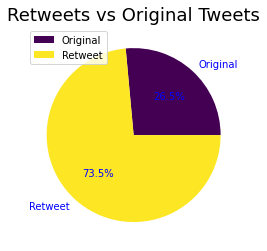

In [9]:
plt.figure()
graph_is_rt.plot(kind="pie", cmap='viridis', subplots = 'True',  autopct='%1.1f%%', textprops={'color':"b"})

    
plt.xlabel('', fontsize=16)
plt.ylabel('', fontsize=16)
plt.title('Retweets vs Original Tweets', fontsize = 18)

#### Step 5.2
We will now determine which hashtags are the most popular within our dataset. Afterwards we will plot a wordclud containing the most popular hashtags.

To achieve this, we will use a function that selects all the hashtags, groups by themselves and applies the aggregate function "count" to obtain the number of times each hashtag appears in our dataframe in lowercase.

In [10]:
from pyspark.sql.functions import *
hashtags_grouped = (omicron_std
      .select(explode("entities.hashtags.text").alias("hashtag"))
      .groupBy(lower("hashtag").alias('hashtag'))
      .agg(count("*").alias("total"))
      .orderBy(desc("total")))
      
hashtags_grouped.limit(10).toPandas()

hashtag  total
0         omicron    339
1  omicronvariant    193
2         covid19     92
3     southafrica     23
4           covid     22
5    covidvariant     11
6            mufc      9
7        breaking      9
8        lockdown      8
9             who      7

Text(0.5, 1.0, '10 Most Popular Hashtags')

<Figure size 432x288 with 0 Axes>

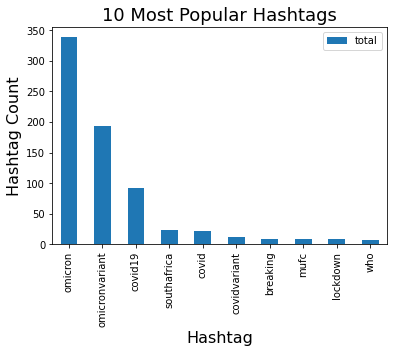

In [11]:
hashtags_graph = hashtags_grouped.limit(10).toPandas().set_index('hashtag')
plt.figure()
hashtags_graph.plot(kind="bar", cmap='tab20')

plt.xlabel('Hashtag', fontsize=16)
plt.ylabel('Hashtag Count', fontsize=16)
plt.title('10 Most Popular Hashtags', fontsize = 18)

In [12]:
hashtags = (omicron_std.select(explode("entities.hashtags.text").alias("hashtag")))

hashtags=hashtags.withColumn('hashtag', lower(col('hashtag')))

In [13]:
text = " ".join(i for i in hashtags.toPandas()['hashtag'].astype(str))

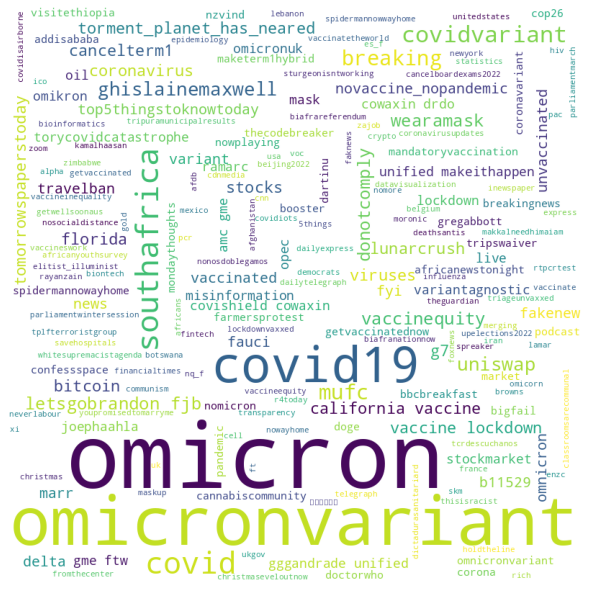

In [14]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(text)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

#### Step 5.3
Now we will look at the most popular accounts mentioned in the tweets.

First we will use a function that selects all the twitter accounts, groups by themselves and applies the aggregate function "count" to obtain the number of times each account appears in our dataframe.

In [15]:
handles_grouped = (omicron_std
      .select(explode("entities.user_mentions.screen_name").alias("handles"))
      .groupBy("handles")
      .agg(count("*").alias("total"))
      .orderBy(desc("total")))
      
handles_grouped.limit(10).toPandas()

handles  total
0    benshapiro    310
1  MartinSLewis    104
2  TheMarcitect     80
3    owenbarder     68
4    RWMaloneMD     68
5    DrEricDing     45
6      brithume     40
7  AITCofficial     39
8       BNODesk     37
9       Reuters     35

Text(0.5, 1.0, '10 Most Popular Handles')

<Figure size 432x288 with 0 Axes>

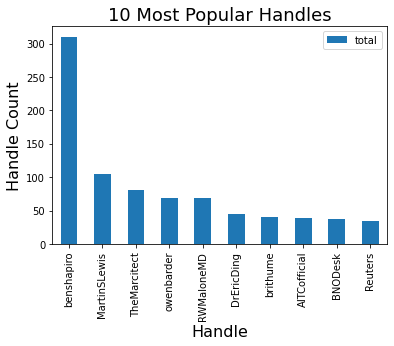

In [16]:
handles_graph = handles_grouped.limit(10).toPandas().set_index('handles')
plt.figure()
handles_graph.plot(kind="bar", cmap='tab20')

plt.xlabel('Handle', fontsize=16)
plt.ylabel('Handle Count', fontsize=16)
plt.title('10 Most Popular Handles', fontsize = 18)

In [17]:
handles = (omicron_std.select(explode("entities.user_mentions.screen_name").alias("handle")))

handles = handles.withColumn('handle', col('handle'))

In [18]:
text = " ".join(i for i in handles.toPandas()['handle'].astype(str))

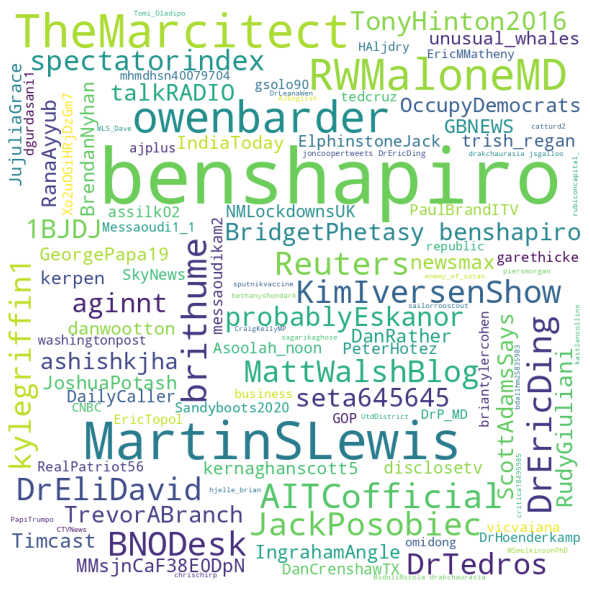

In [19]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(text)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [20]:
omicron_std.limit(5).toPandas()

created_at                   id               id_str  \
0 2021-11-29 15:14:40  1465323328793624581  1465323328793624581   
1 2021-11-29 15:14:40  1465323328567132182  1465323328567132182   
2 2021-11-29 15:14:40  1465323329624100870  1465323329624100870   
3 2021-11-29 15:14:40  1465323329645162500  1465323329645162500   
4 2021-11-29 15:14:40  1465323330316095494  1465323330316095494   

                                                                                                                                           text  \
0  RT @mohammedhersi: Go get the jab.....its all free. In light of Omicron  all the reason.  @KEPSA_KENYA . Jikinge. @MOH_Kenya @DrPatrickAmot‚Ä¶   
1  #Africans are saying it started in #Belgium, but because #Elitist_Illuminist #WhiteSupremacistAgenda wants to ban/r‚Ä¶ https://t.co/dZbRpoRUGJ   
2                               RT @benshapiro: So, quick question for the legacy media today: which is more deadly, Omicron, or unmanned SUVs?   
3                                                        @LiamThorpECHO I hope this is just a coincidence but OMICRON  is an anagram of MORONIC   
4                                           ahem #Omicron \nlike to reiterate my fav line :"The smart are being led by the stupid..."\n#COVID19   

                                                                                 source  \
0  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   
1  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   
2    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
3               <a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>   
4               <a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>   

   truncated  in_reply_to_status_id in_reply_to_status_id_str  \
0      False                    NaN                      None   
1       True                    NaN                      None   
2      False                    NaN                      None   
3      False           1.464945e+18       1464945276456783875   
4      False                    NaN                      None   

   in_reply_to_user_id in_reply_to_user_id_str  ... favorite_count  \
0                  NaN                    None  ...              0   
1                  NaN                    None  ...              0   
2                  NaN                    None  ...              0   
3         1.444111e+09              1444110548  ...              0   
4                  NaN                    None  ...              0   

                                                                                                                                                 entities  \
0                                                                                    ([(mohammedhersi,), (KEPSA_KENYA,), (MOH_Kenya,)], [], None, [], [])   
1  ([], [(Africans,), (Belgium,), (Elitist_Illuminist,), (WhiteSupremacistAgenda,)], None, [(https://twitter.com/i/web/status/1465323328567132182,)], [])   
2                                                                                                                     ([(benshapiro,)], [], None, [], [])   
3                                                                                                                  ([(LiamThorpECHO,)], [], None, [], [])   
4                                                                                                            ([], [(Omicron,), (COVID19,)], None, [], [])   

  favorited retweeted  possibly_sensitive filter_level  lang  year  \
0     False     False                None          low    en  2021   
1     False     False               False          low    en  2021   
2     False     False                None          low    en  2021   
3     False     False                None          low    en  2021   
4     False     False                None          low    en  2021   

### Step 6. Sentiment Analysis

#### Step 6.1 Data Cleansing

We will use two diferent algorithms to determine the sentiment behind the tweets in the dataset, but in order to properly implement these algoriths, we will first clean the dataset according to the following rules:

##### Rule 1. Most of the tweets are Retweets, so we will remove the RT and the following handle.

##### Rule 2 All twitter handles must be removed from the text.

##### Rule 3. All hashtags must be removed from the text.

##### Rule 4. All URLs must be removed.

##### Rule 5. Punctuation does not offer any information, so it will be removed as well.

##### Rule 6. All words must be lowercase.

Using the following regular expressions, we will create 6 new columns, which will apply the aforementioned rules to our dataframe

In [21]:
omicron_std = omicron_std.withColumn("text_no_rt", F.regexp_replace("text", r'RT @\w+: ', " ")) #Removes RT and the following handle
omicron_std = omicron_std.withColumn("text_no_handle", F.regexp_replace("text_no_rt", r'(@[A-Za-z0-9_-]+)', " ")) #Removes handles
omicron_std = omicron_std.withColumn("text_no_hashtags", F.regexp_replace("text_no_handle", r'(#[A-Za-z0-9_-]+)', " ")) #Removes hashtags
omicron_std = omicron_std.withColumn("text_no_urls", F.regexp_replace("text_no_hashtags", r'(\w+:\/\/\S+)', " ")) #Removes urls
omicron_std = omicron_std.withColumn("text_no_punct", F.regexp_replace("text_no_urls", r'[\.\,\!\?\:\;\-\=\"]', " ")) #Removes punctuation
omicron_std = omicron_std.withColumn('text_lower', lower(col('text_no_punct'))) #lower cases everything

#### Step 6.2 Applying the Algorithm

We will use two diferent Sentiment intensity analyzers to extract a negative, neutral and positive score for each tweet. The aforementioned scores are also compounded into a single score, ranging from -1 (negative sentiment) to +1 (positive sentiment)

The sentiment intensity analyzers are the following:

NLTK (Natural Language Toolkit's) VADER (Valence Aware Dictionary and sEntiment Reasoner)

vaderSentiment's VADER (Valence Aware Dictionary and sEntiment Reasoner)

In [22]:
from nltk.sentiment import vader
from vaderSentiment import vaderSentiment

nltk = vader.SentimentIntensityAnalyzer()
vader = vaderSentiment.SentimentIntensityAnalyzer()

In order to use both SIA in the Spark dataframe, we will create two user defined functions and apply these functions to the 'text_lower' column, which represents our last transformation

In [23]:
from pyspark.sql.functions import udf
from pyspark.sql.types import MapType, StringType, FloatType

nltk_polaritytUDF = udf(lambda z: nltk.polarity_scores(z), MapType(StringType(), FloatType()))
vaderS_polarityUDF = udf(lambda z: vader.polarity_scores(z), MapType(StringType(), FloatType()))

omicron_std = omicron_std.withColumn('nltk', nltk_polaritytUDF(omicron_std['text_lower']))
omicron_std = omicron_std.withColumn('vader', vaderS_polarityUDF(omicron_std['text_lower']))

In [24]:
omicron_std.limit(10).toPandas()

created_at                   id               id_str  \
0 2021-11-29 15:14:40  1465323328793624581  1465323328793624581   
1 2021-11-29 15:14:40  1465323328567132182  1465323328567132182   
2 2021-11-29 15:14:40  1465323329624100870  1465323329624100870   
3 2021-11-29 15:14:40  1465323329645162500  1465323329645162500   
4 2021-11-29 15:14:40  1465323330316095494  1465323330316095494   
5 2021-11-29 15:14:41  1465323330458857477  1465323330458857477   
6 2021-11-29 15:14:41  1465323330639220751  1465323330639220751   
7 2021-11-29 15:14:41  1465323331188662282  1465323331188662282   
8 2021-11-29 15:14:41  1465323331117150213  1465323331117150213   
9 2021-11-29 15:14:41  1465323331654238221  1465323331654238221   

                                                                                                                                            text  \
0   RT @mohammedhersi: Go get the jab.....its all free. In light of Omicron  all the reason.  @KEPSA_KENYA . Jikinge. @MOH_Kenya @DrPatrickAmot‚Ä¶   
1   #Africans are saying it started in #Belgium, but because #Elitist_Illuminist #WhiteSupremacistAgenda wants to ban/r‚Ä¶ https://t.co/dZbRpoRUGJ   
2                                RT @benshapiro: So, quick question for the legacy media today: which is more deadly, Omicron, or unmanned SUVs?   
3                                                         @LiamThorpECHO I hope this is just a coincidence but OMICRON  is an anagram of MORONIC   
4                                            ahem #Omicron \nlike to reiterate my fav line :"The smart are being led by the stupid..."\n#COVID19   
5    Applied DNA Stock Surges On Launch Plans For Linea 2.0 COVID-19 Assay For Omicron Variant ‚Äì Applied DNA Sciences (‚Ä¶ https://t.co/uvfu66Owth   
6              RT @IdahoTribune: Laboratory Worker Spells ‚ÄúHELP‚Äù in Tape During News Broadcast on COVID Omicron Variant\nhttps://t.co/gAIfyEBfj3   
7  RT @seta645645: To Non-Arabs and Arabs... The Planet of Torment Has Approached\nImam Mahdi Nasser Mohammad Al-Yamani\n08 - Rabi Awwal - 1443‚Ä¶   
8        RT @CNNPolitics: Federal officials are bracing for the first detection of Omicron coronavirus variant in the US https://t.co/SER988ZFwv   
9    RT @BridgetPhetasy: @benshapiro More infuriating: they're taking it out on Africa. South Africa is being punished for discovering Omicron.‚Ä¶   

                                                                                 source  \
0  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   
1  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   
2    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
3               <a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>   
4               <a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>   
5               <a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>   
6    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
7               <a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>   
8    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
9               <a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>   

   truncated  in_reply_to_status_id in_reply_to_status_id_str  \
0      False                    NaN                      None   
1       True                    NaN                      None   
2      False                    NaN                      None   
3      False           1.464945e+18       1464945276456783875   
4      False                    NaN                      None   
5       True                    NaN                      None   
6      False                    NaN                      None   
7      False                    NaN                      None   
8      False                    NaN      

As emojis also carry sentiment, we will analyze wether any of our SIAs actually carry this sentiment into their calculations.

In [25]:
import emojis

@udf("array<string>")
def get_emojis_udf(s):
    set = emojis.get(s)
    return [*set, ]

emoji_df = omicron_std.select(explode(get_emojis_udf("text_lower")).alias("emoji"))\
      .groupBy("emoji").agg(count("*").alias("total")).orderBy(desc("total")).limit(20)

emoji_df = emoji_df.withColumn('nltk', nltk_polaritytUDF(emoji_df['emoji']))
emoji_df = emoji_df.withColumn('vader', vaderS_polarityUDF(emoji_df['emoji']))

emoji_df.toPandas()

emoji  total                                                   nltk  \
0      üëá     34  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 0.0}   
1     üá≥üá±     25  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 1.0}   
2     ‚úàÔ∏è     24  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 1.0}   
3      üé•     23  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 0.0}   
4      üö®     22  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 0.0}   
5      üé¨     22  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 0.0}   
6     üìΩÔ∏è     22  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 1.0}   
7      üò∑     16  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 0.0}   
8     üáøüá¶     10  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 1.0}   
9      üíâ      9  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 0.0}   
10     üòÇ      9  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 0.0}   
11    ‚û°Ô∏è      9  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 1.0}   
12    ‚úñÔ∏è      8  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 1.0}   
13     ü§£      8  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 0.0}   
14     ‚úÖ      8  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 0.0}   
15    ‚úîÔ∏è      8  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 1.0}   
16     üí©      7  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 0.0}   
17     üò°      7  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 0.0}   
18     üí•      7  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 0.0}   
19     üëÄ      6  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 0.0}   

                                                                                                                   vader  
0                                                                  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 1.0}  
1                                                                  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 1.0}  
2                                                                  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 1.0}  
3                                                                  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 1.0}  
4                                                                  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 1.0}  
5                                                                  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 1.0}  
6                                                                  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 1.0}  
7                                                                  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 1.0}  
8                                                                  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 1.0}  
9                                                                  {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 1.0}  
10  {'neg': 0.21799999475479126, 'pos': 0.43700000643730164, 'compound': 0.44040000438690186, 'neu': 0.3449999988079071}  
11                                                                 {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 1.0}  
12                                                                 {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 1.0}  
13                   {'neg': 0.0, 'pos': 0.4440000057220459, 'compound': 0.49390000104904175, 'neu': 0.5559999942779541}  
14                                                                 {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 1.0}  
15                                                                 {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 1.0}  
16                                                                 {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 1.0}  
17                                                                 {'neg': 0.0, 'pos': 0.0, 'compound': 0.0, 'neu': 1.0}  
18                                      

Text(0.5, 1.0, 'Most Popular Emojis')

<Figure size 432x288 with 0 Axes>

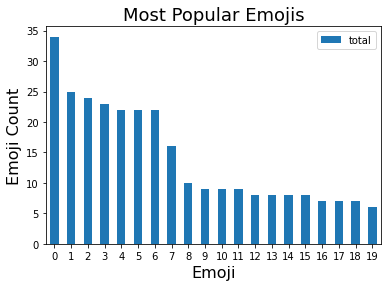

In [26]:
plt.figure()
axis = emoji_df.toPandas().plot(kind="bar", cmap='tab20')

plt.xlabel('Emoji', fontsize=16)
plt.ylabel('Emoji Count', fontsize=16)
axis.set_xticklabels(labels = emoji_df.toPandas().index.values, rotation=0, fontsize=10)
plt.title('Most Popular Emojis', fontsize = 18)

Most of the emojis carry no sentiment on both of the SIAs, but the vaderSentiment analyzer takes into account some of them, thus we will leave the emojis in the dataframe.

#### Step 6.3 Results

Using the compound scores of both Sentiment Intensity Analizers, we are able to plot the results of our dataframe's overall sentiment

In [27]:
omicron_std.limit(5).toPandas().nltk[0]['compound']

0.5105999708175659

In [28]:
omicron_std = omicron_std.withColumn('nltk_comp', col('nltk')['compound'])
omicron_std = omicron_std.withColumn('vader_comp', col('vader').compound)

In [29]:
nltk_comp = omicron_std.select('nltk_comp').toPandas()

Text(0.5, 1.0, 'NLTK Sentiment Values')

<Figure size 432x288 with 0 Axes>

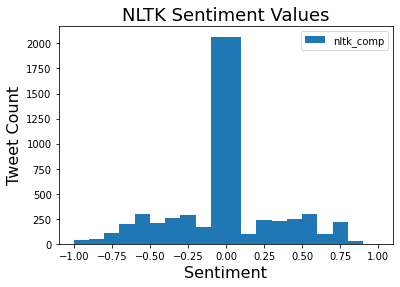

In [30]:
nltk_comp = omicron_std.select('nltk_comp').toPandas()
plt.figure()

#nltk_comp = nltk_comp[nltk_comp['vader_comp'] != 0]
axis = nltk_comp.plot(kind="hist", cmap='tab20', bins=[-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2,\
                                                        -0.1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])


plt.xlabel('Sentiment', fontsize=16)
plt.ylabel('Tweet Count', fontsize=16)
plt.title('NLTK Sentiment Values', fontsize = 18)

Text(0.5, 1.0, 'NLTK Sentiment Values')

<Figure size 432x288 with 0 Axes>

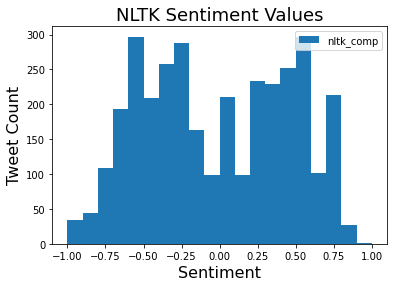

In [31]:
nltk_comp = omicron_std.select('nltk_comp').toPandas()
plt.figure()

nltk_comp = nltk_comp[nltk_comp['nltk_comp'] != 0]
axis = nltk_comp.plot(kind="hist", cmap='tab20', bins=[-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2,\
                                                        -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])


plt.xlabel('Sentiment', fontsize=16)
plt.ylabel('Tweet Count', fontsize=16)
plt.title('NLTK Sentiment Values', fontsize = 18)

Text(0.5, 1.0, 'Vader Sentiment Values')

<Figure size 432x288 with 0 Axes>

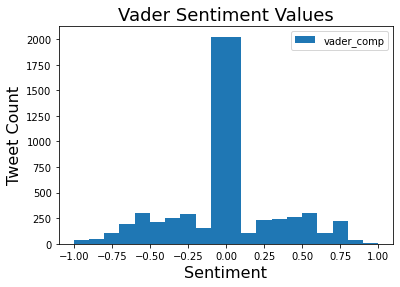

In [32]:
vader_comp = omicron_std.select('vader_comp').toPandas()
plt.figure()
# Remove polarity values equal to zero
# vader_comp = vader_comp[vader_comp['vader_comp'] != 0]
axis = vader_comp.plot(kind="hist", cmap='tab20', bins=[-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2,\
                                                        -0.1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

plt.xlabel('Sentiment', fontsize=16)
plt.ylabel('Tweet Count', fontsize=16)
plt.title('Vader Sentiment Values', fontsize = 18)

Text(0.5, 1.0, 'Vader Sentiment Values')

<Figure size 432x288 with 0 Axes>

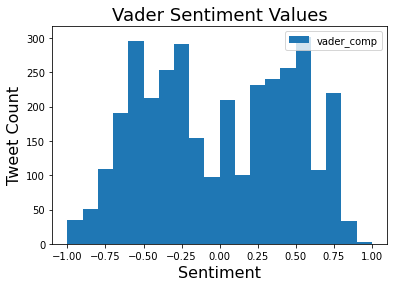

In [33]:
vader_comp = omicron_std.select('vader_comp').toPandas()
plt.figure()
# Remove polarity values equal to zero
vader_comp = vader_comp[vader_comp['vader_comp'] != 0]
axis = vader_comp.plot(kind="hist", cmap='tab20', bins=[-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2,\
                                                        -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

plt.xlabel('Sentiment', fontsize=16)
plt.ylabel('Tweet Count', fontsize=16)
plt.title('Vader Sentiment Values', fontsize = 18)